In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from tensorflow.python.framework import ops
from tf_utils import load_dataset, random_mini_batches, convert_to_one_hot, predict

%matplotlib inline

In [2]:
def sigmoid(z):
    """
    Computes the sigmoid of z
    
    Arguments:
    z -- input value, scalar or vector
    
    Returns: 
    results -- the sigmoid of z
    """
    
    x = tf.placeholder(tf.float32, name = 'x')

    sigmoid = tf.sigmoid(x)
    with tf.Session() as sess: 
        result = sess.run(sigmoid, feed_dict = {x: z})
    
    return result

In [3]:
def cost(logits, labels):
    """
    Computes the cost using the sigmoid cross entropy
    
    Arguments:
    logits -- vector containing z, output of the last linear unit (before the final sigmoid activation)
    labels -- vector of labels y (1 or 0) 
    
    Note: What we've been calling "z" and "y" in this class are respectively called "logits" and "labels" 
    in the TensorFlow documentation. So logits will feed into z, and labels into y. 
    
    Returns:
    cost -- runs the session of the cost (formula (2))
    """
    
    z = tf.placeholder(tf.float32, name = 'z')
    y = tf.placeholder(tf.float32, name = 'y')
    
    cost = tf.nn.sigmoid_cross_entropy_with_logits(logits = z,  labels = y)
    
    sess = tf.Session()

    cost = sess.run(cost, feed_dict = {z: logits, y: labels})
    
    sess.close()
     
    return cost

In [4]:
def one_hot_matrix(labels, C):
    """
    Creates a matrix where the i-th row corresponds to the ith class number and the jth column
                     corresponds to the jth training example. So if example j had a label i. Then entry (i,j) 
                     will be 1. 
                     
    Arguments:
    labels -- vector containing the labels 
    C -- number of classes, the depth of the one hot dimension
    
    Returns: 
    one_hot -- one hot matrix
    """
    C = tf.constant(C, name='C')
    
    one_hot_matrix = tf.one_hot(labels, C, axis=0)
    
    sess = tf.Session()
    
    one_hot = sess.run(one_hot_matrix)

    sess.close()   
    return one_hot

In [5]:
def ones(shape):
    """
    Creates an array of ones of dimension shape
    
    Arguments:
    shape -- shape of the array you want to create
        
    Returns: 
    ones -- array containing only ones
    """
    ones = tf.ones(shape)
    sess = tf.Session()
    ones = sess.run(ones)

    sess.close()
    return ones

In [6]:
def create_placeholders(n_x, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_x -- scalar, size of an image vector (num_px * num_px = 64 * 64 * 3 = 12288)
    n_y -- scalar, number of classes (from 0 to 5, so -> 6)
    
    Returns:
    X -- placeholder for the data input, of shape [n_x, None] and dtype "tf.float32"
    Y -- placeholder for the input labels, of shape [n_y, None] and dtype "tf.float32"
    
    Tips:
    - You will use None because it let's us be flexible on the number of examples you will for the placeholders.
      In fact, the number of examples during test/train is different.
    """

    X = tf.placeholder(tf.float32, shape= [n_x, None], name = "X")
    Y = tf.placeholder(tf.float32, shape= [n_y, None], name = "Y")
    
    return X, Y

In [7]:
def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    Z1 = tf.add(tf.matmul(W1,X), b1)                                         
    A1 = tf.nn.relu(Z1)                                           
    Z2 = tf.add(tf.matmul(W2,A1), b2)                             
    A2 = tf.nn.relu(Z2)                                          
    Z3 = tf.add(tf.matmul(W3,A2), b3)                                    
    
    return Z3

In [8]:
def compute_cost(Z3, Y):
    """
    Computes the cost
    
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = labels))
    
    return cost

In [9]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001,
          num_epochs = 1500, minibatch_size = 32, print_cost = True):
    """
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.
    
    Arguments:
    X_train -- training set, of shape (input size = 12288, number of training examples = 1080)
    Y_train -- test set, of shape (output size = 6, number of training examples = 1080)
    X_test -- training set, of shape (input size = 12288, number of training examples = 120)
    Y_test -- test set, of shape (output size = 6, number of test examples = 120)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                                                                             
    (n_x, m) = X_train.shape                  
    n_y = Y_train.shape[0]                           
    costs = []                                       
    
    X, Y = create_placeholders(n_x, n_y)
    parameters = initialize_parameters()

    Z3 = forward_propagation(X, parameters)
    
    cost = compute_cost(Z3, Y)

    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)

    init = tf.global_variables_initializer()

    with tf.Session() as sess:
        
        sess.run(init)

        for epoch in range(num_epochs):

            epoch_cost = 0.                     
            num_minibatches = int(m / minibatch_size)
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                (minibatch_X, minibatch_Y) = minibatch
                
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                
                epoch_cost += minibatch_cost / num_minibatches

            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per fives)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))

        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        
        return parameters

In [10]:
train = pd.read_csv("trian_set.csv")

In [105]:
print(train)

        0        1        2        3        4        5        6        7  \
0     0.0  2681.02  2680.88  2680.89  2680.92  2680.58  2680.37  2680.40   
1     1.0  2554.23  2554.25  2554.34  2554.01  2553.90  2554.16  2554.16   
2     1.0  2494.45  2494.00  2494.42  2494.91  2494.96  2495.07  2495.03   
3     0.0  2506.70  2507.13  2506.72  2506.84  2506.97  2506.74  2506.54   
4     1.0  2890.07  2890.37  2890.48  2890.54  2891.89  2890.97  2889.70   
5     0.0  2747.50  2747.67  2747.69  2747.66  2747.65  2747.73  2747.40   
6     1.0  2783.66  2783.28  2783.52  2783.94  2782.92  2782.14  2781.31   
7     1.0  2381.08  2381.02  2381.09  2381.06  2381.27  2381.41  2381.35   
8     1.0  2746.22  2746.59  2746.48  2746.67  2746.72  2747.07  2746.74   
9     1.0  2750.57  2751.21  2752.31  2751.78  2751.15  2750.62  2750.08   
10    0.0  2792.43  2793.48  2792.93  2791.90  2790.30  2790.82  2790.41   
11    0.0  2443.27  2443.56  2443.61  2442.58  2443.03  2443.92  2444.39   
12    1.0  2

In [11]:
trainArray = np.array(train)
print(trainArray)
X_train_orig = trainArray[:, 1:]
Y_train_orig = trainArray[:, 0].reshape(1,1500).astype(int)
test = pd.read_csv("test_set.csv")
testArray = np.array(test)
X_test_orig = testArray[:, 1:]
Y_test_orig = testArray[:, 0].reshape(1,359).astype(int)
print(X_train_orig.shape)
print(Y_train_orig.shape)

[[  0.00000000e+00   2.66057000e+03   2.65937000e+03 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  1.00000000e+00   2.93324000e+03   2.93307000e+03 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  1.00000000e+00   2.70375000e+03   2.70358000e+03 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 ..., 
 [  1.00000000e+00   2.57476000e+03   2.57478000e+03 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  1.00000000e+00   2.67703000e+03   2.67707000e+03 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  1.00000000e+00   2.29411000e+03   2.29446000e+03 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]]
(1500, 5979)
(1, 1500)


In [12]:
X_train_flatten = X_train_orig.reshape(X_train_orig.shape[0], -1).T
X_test_flatten = X_test_orig.reshape(X_test_orig.shape[0], -1).T
X_train = X_train_flatten
X_test = X_test_flatten
Y_train = convert_to_one_hot(Y_train_orig,2)
Y_test = convert_to_one_hot(Y_test_orig,2)

print ("number of training examples = " + str(X_train.shape[1]))
print ("number of test examples = " + str(X_test.shape[1]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1500
number of test examples = 359
X_train shape: (5979, 1500)
Y_train shape: (2, 1500)
X_test shape: (5979, 359)
Y_test shape: (2, 359)


In [14]:
X, Y = create_placeholders(5979, 2)
print ("X = " + str(X))
print ("Y = " + str(Y))

X = Tensor("X_1:0", shape=(5979, ?), dtype=float32)
Y = Tensor("Y_1:0", shape=(2, ?), dtype=float32)


In [23]:
def initialize_parameters():
    """
    Initializes parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [25, 12288]
                        b1 : [25, 1]
                        W2 : [12, 25]
                        b2 : [12, 1]
                        W3 : [6, 12]
                        b3 : [6, 1]
    
    Returns:
    parameters -- a dictionary of tensors containing W1, b1, W2, b2, W3, b3
    """
    
    tf.set_random_seed(1)                   # so that your "random" numbers match ours
        
    W1 = tf.get_variable("W1", [25,5979], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b1 = tf.get_variable("b1", [25,1], initializer = tf.zeros_initializer())
    W2 = tf.get_variable("W2", [12,25], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b2 = tf.get_variable("b2", [12,1], initializer = tf.zeros_initializer())
    W3 = tf.get_variable("W3", [2,12], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b3 = tf.get_variable("b3", [2,1], initializer = tf.zeros_initializer())

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

Cost after epoch 0: 9.289794
Cost after epoch 100: 0.483114
Cost after epoch 200: 0.354324
Cost after epoch 300: 0.206277
Cost after epoch 400: 0.147042
Cost after epoch 500: 0.090229
Cost after epoch 600: 0.094887
Cost after epoch 700: 0.063658
Cost after epoch 800: 0.038117
Cost after epoch 900: 0.029079
Cost after epoch 1000: 0.031158
Cost after epoch 1100: 0.035730
Cost after epoch 1200: 0.031199
Cost after epoch 1300: 0.025991
Cost after epoch 1400: 0.049639


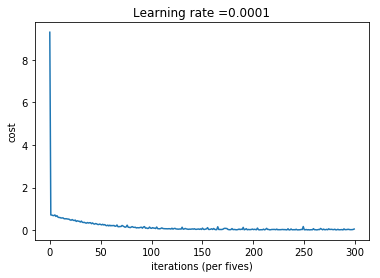

Parameters have been trained!
Train Accuracy: 0.964
Test Accuracy: 0.534819


In [24]:
parameters = model(X_train, Y_train, X_test, Y_test)